## Speed-gradient algorithm for the problem of classifying dynamic objects using neural networks

###### Delta version

In [1]:
import warnings
warnings.simplefilter('ignore')

%matplotlib inline

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV

import torch
from torch import nn, tensor, optim
import torch.nn.functional as F

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


#### Generating data

In [2]:
number_of_objects = 6
number_of_observations = 2
number_of_axes = 2
names_of_axes = ['x', 'y']
obs = ''
axis_index = []

observations = np.random.randn(number_of_objects, number_of_observations*number_of_axes)

observations = np.array([[1., 1., 2., 2.],
                         [0., 1., 1., 2.],
                         [1., -1., 3., 1.],
                         [0., -1., -1., -2.],
                         [-1., -1., -3., -3.],
                         [-1., 1., -2., 0.]])

target = np.array([1., 1., 1., -1, -1, -1])

observations = observations.T
        
for i in range(1, number_of_observations+1):
    obs += str(i) + ' ' + str(i) + ' '
    for j in names_of_axes:
        axis_index.append(j)
    
observations_index = obs.split()
hier_index = list(zip(observations_index,axis_index))
hier_index = pd.MultiIndex.from_tuples(hier_index)

df = pd.DataFrame(observations, index=hier_index)
df.columns.name = 'object'
df.index.names = ['observation', 'axis']
df = df.T
df['time'] = 0
df['target'] = target
#df = df.dropna(axis='index', how='any')
df.to_csv('data.csv', sep='\t', encoding='utf-8')
df.head(6)


observation    1         2      time target
axis           x    y    x    y            
object                                     
0            1.0  1.0  2.0  2.0    0    1.0
1            0.0  1.0  1.0  2.0    0    1.0
2            1.0 -1.0  3.0  1.0    0    1.0
3            0.0 -1.0 -1.0 -2.0    0   -1.0
4           -1.0 -1.0 -3.0 -3.0    0   -1.0
5           -1.0  1.0 -2.0  0.0    0   -1.0

#### Creating tensors

In [3]:
# N is batch size; D_in is input dimension; D_out is output dimension.
N, D_in, D_out = number_of_objects, number_of_observations*number_of_axes, 1
data = df.iloc[:, :D_in + 1]
X = torch.tensor(df.iloc[:, :D_in + 1].values, dtype=torch.float32)
z = torch.tensor(df['target'].values, dtype=torch.float32).view(N, D_out)
    
#######
device = torch.device('cuda:0' 
                      if torch.cuda.is_available() 
                      else 'cpu')
X = X.to(device)
#######


#### Model

In [4]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(D_in, D_out)
        self.linear2 = nn.Linear(D_in, D_out)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        time = x[:, D_in].view(D_out, N)
        x = x[:, :D_in]
        x1 = self.linear1(x)
        x2 = self.linear2(torch.mm(time, x))
        x = x1 + x2
        z_pred = self.sigmoid(x) * 2 - 1
        return z_pred

model = Model()


#### Training

Epoch: 99 | Loss: 0.08491223305463791 
Epoch: 199 | Loss: 0.040117047727108 
Epoch: 299 | Loss: 0.02611699141561985 
Epoch: 399 | Loss: 0.019319579005241394 
Epoch: 499 | Loss: 0.015313252806663513 


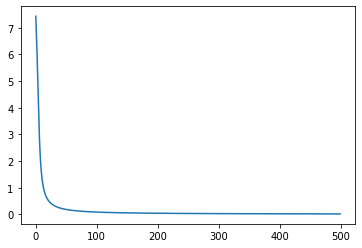

In [5]:
losses = []

learning_rate = 1e-2
loss_fn = nn.MSELoss(reduction='sum')
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(500):
    z_pred = model(X)
    loss = loss_fn(z_pred, z) / 2
    
    if epoch % 100 == 99:
        print(f'Epoch: {epoch} | Loss: {loss.item()} ')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
plt.figure()
plt.plot(losses, '-')
plt.show()


In [6]:
print(loss.grad_fn)
print(loss.grad_fn.next_functions[0][0])
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])
print(loss.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0])
print(loss.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions[0][0])
print(loss.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions[0][0])
print(loss.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions[0][0])


weights: OrderedDict([('linear1.weight', tensor([[0.5293, 0.3559, 1.1876, 0.7858]])), ('linear1.bias', tensor([-0.2811])), ('linear2.weight', tensor([[ 0.1341, -0.0099,  0.3964, -0.0444]])), ('linear2.bias', tensor([0.0438]))])
z_pred: tensor([[ 0.9800],
        [ 0.8934],
        [ 0.9728],
        [-0.9323],
        [-0.9982],
        [-0.8837]])


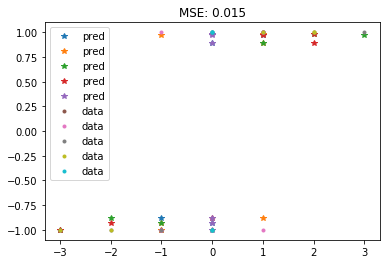

In [7]:
print('weights:', model.state_dict())
print('z_pred:', z_pred.data)

fig, ax = plt.subplots()
ax.plot(X.detach().numpy(), z_pred.detach().numpy(), "*", label="pred")
ax.plot(X.detach().numpy(), z.detach().numpy(), ".", label="data")
ax.set_title(f"MSE: {loss.item():0.3f}")
ax.legend();


In [8]:
test = torch.tensor(df.iloc[:, :D_in + 1].values, dtype=torch.float32)
test[0][:] = torch.tensor([2., 2., 3., 3., 0.])
test[1][:] = torch.tensor([1., 2., 2., 3., 0.])
test[2][:] = torch.tensor([3., 1., 5., 3., 0.])
test[3][:] = torch.tensor([-1., -2., -2., -3., 0.])
test[4][:] = torch.tensor([-3., -3., -5., -5., 0.])
test[5][:] = torch.tensor([-2., 0., -3., -1., 0.])

loss = loss_fn(model(test), z) / 2

print('test_pred: ', np.rint(model(test).data.numpy()).T,  'test_target: ', z.numpy().T, 'loss:', int(loss.item()),  sep = '\n')


test_pred: 
[[ 1.  1.  1. -1. -1. -1.]]
test_target: 
[[ 1.  1.  1. -1. -1. -1.]]
loss:
0
